In [1]:
from transformers import BertTokenizer, BertModel

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

from dataset import Dataset

import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle

from CNNText import CNNText

In [2]:
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5

model = CNNText(
    embed_dim=768,
    embed_num=512,
    class_num=6,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout
).to('cpu')

model.load_state_dict(torch.load('../cnn_models/random_seed_2_epoch_75.p', map_location=torch.device('cpu')))

processed_experiment_path = "../data/experiment_pre_processed"
experiment_dataset = Dataset(processed_experiment_path)

In [5]:
# predict_class() returns the predicted class of an input vector
def predict_class(model, X):
    model = model.eval()
    outputs = model(Variable(X))
    _, pred = torch.max(outputs.data, 1)
    model = model.train()
    return pred.numpy()

# predict() forwards an input T times through the model and returns 
# the probability distribution to interpret the model uncertainty
def predict(model, X, T=1000):
    standard_pred = predict_class(model, X)
    y1 = []
    y2 = []
    for _ in range(T):
        _y1 = model(Variable(X))
        _y2 = F.softmax(_y1, dim=1)
        y1.append(_y1.data.numpy())
        y2.append(_y2.data.numpy())
    return standard_pred, np.array(y1), np.array(y2)

In [6]:
# In this cell the experiment dataset is forwarded through the network and the results are
# stored and printed before they can be plotted
x_tensor = torch.empty((1,512,768), dtype = torch.float64)
for i in range(0, len(experiment_dataset)):
    x, y = experiment_dataset[i]
    x_tensor = torch.cat((x_tensor, x), dim = 0)

sentence_mods = len(experiment_dataset)+1
indices = torch.LongTensor(range(1, sentence_mods))
x_tensor = x_tensor.index_select(0, indices)

y1_pred, y1_si, y1_so = predict(model, x_tensor.float().to('cpu'))

print('Predictions: {}'.format(y1_pred))

Predictions: [2 2 2 2 2]


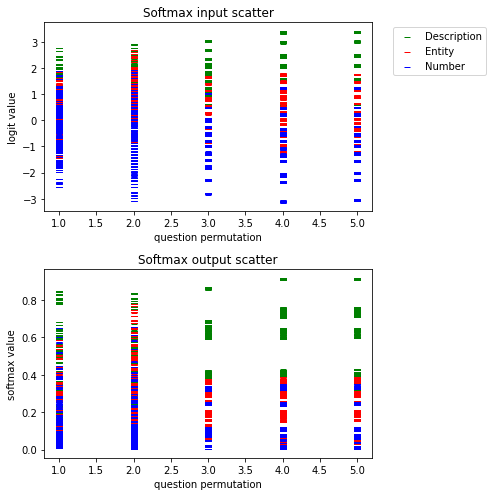

In [7]:
# Here we plot the returned probability distributions of an input forwarded through the network
# for the 3 most relevant classes. These should be manually selected.
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.xlabel('question permutation')
plt.ylabel('logit value')
plt.scatter(np.tile(np.arange(1, sentence_mods), y1_si.shape[0]), y1_si[:, :, 2].flatten(), \
            color='g', marker='_', linewidth=None, alpha=1, label='Description');
plt.scatter(np.tile(np.arange(1, sentence_mods), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='r', marker='_', linewidth=None, alpha=1, label='Entity');
plt.scatter(np.tile(np.arange(1, sentence_mods), y1_si.shape[0]), y1_si[:, :, 5].flatten(), \
            color='b', marker='_', linewidth=None, alpha=1, label='Number');
plt.title('Softmax input scatter');
plt.legend(bbox_to_anchor=(1.05, 1))


plt.subplot(2, 1, 2)
plt.xlabel('question permutation')
plt.ylabel('softmax value')
plt.scatter(np.tile(np.arange(1, sentence_mods), y1_so.shape[0]), y1_so[:, :, 2].flatten(), \
            color='g', marker='_', linewidth=None, alpha=1, label='Description');
plt.scatter(np.tile(np.arange(1, sentence_mods), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='r', marker='_', linewidth=None, alpha=1, label='Entity');
plt.scatter(np.tile(np.arange(1, sentence_mods), y1_so.shape[0]), y1_so[:, :, 5].flatten(), \
            color='b', marker='_', linewidth=None, alpha=1, label='Number');
plt.title('Softmax output scatter');

plt.tight_layout();
plt.savefig('experiment_images/ciaomeaning.png')